In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


### parameters

In [4]:
# _fname = "../replays/local.log"
_fname = "../replays/log12-multi.log"
print("_fname", _fname)
# _fname = "../replays/log13.log"
# _fname = "../replays/selftrade-rev.log"
_time_step = 100
_max_time = 200000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]


_fname ../replays/log12-multi.log


### pre processing

In [5]:
# load data from file

obj = process_file(_fname)
raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", missing_times)


Reading from input file ../replays/log12-multi.log
num missing_times 0
missing_times set()


In [6]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

In [7]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [8]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 2000
Remaining count: 2000
nan count: 0


In [9]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

In [10]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

In [11]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [12]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 192 	volume: 242
[MY]	 count: 335 	volume: 968
[MY]	 vol%: 80.0%
PEARLS
[THEM]	 count: 104 	volume: 194
[MY]	 count: 355 	volume: 556
[MY]	 vol%: 74.13%


In [13]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [14]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4896.0,10001.5
1,100,4894.0,9999.0
2,200,4895.5,10000.0
3,300,4896.0,9997.0
4,400,4896.5,10001.0
...,...,...,...
1995,199500,4908.5,9997.0
1996,199600,4908.5,10000.0
1997,199700,4908.0,10003.0


In [15]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [16]:
# plot trades
def plot_trades_and_book(sym, smooth_alpha=0.1):
    
    plt_df = trade_df[trade_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=25)
    

    bids = book_tops[f"{sym}_best_buy"]
    asks = book_tops[f"{sym}_best_sell"]
    smooth_bids = bids.ewm(alpha=smooth_alpha).mean()
    smooth_asks = asks.ewm(alpha=smooth_alpha).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_tops["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, smooth_asks, c="red", alpha=0.75, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

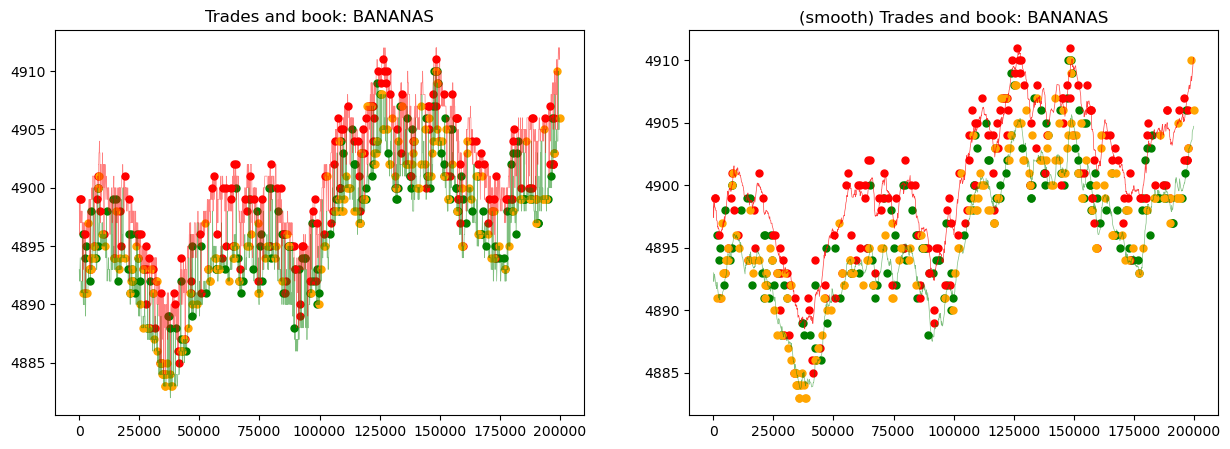

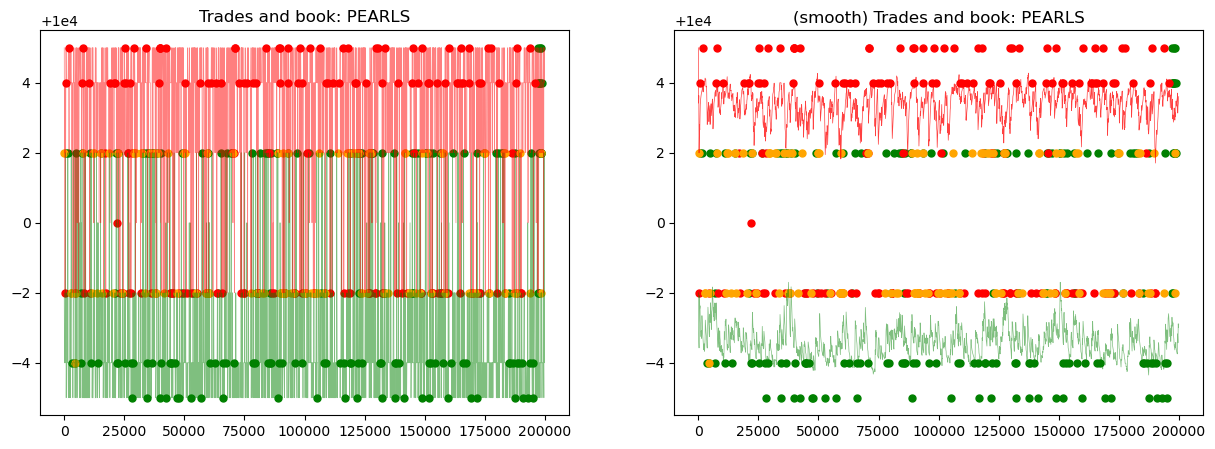

In [17]:
plot_trades_and_book(sym="BANANAS", smooth_alpha=0.1)
plot_trades_and_book(sym="PEARLS")

Text(0.5, 1.0, 'PNL')

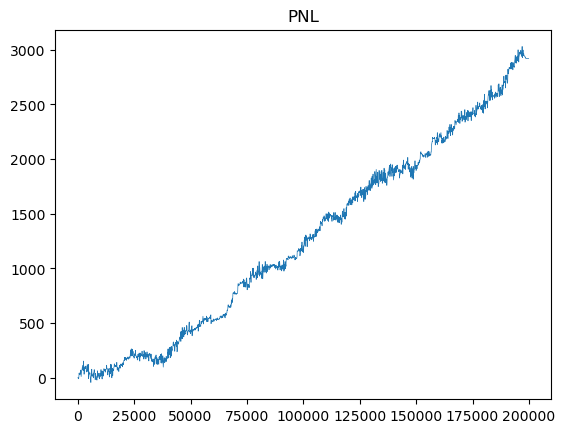

In [18]:
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title("PNL")

In [19]:
my_positions

,BANANAS,PEARLS,cash,time,turn,pnl
0,0.0,0.0,0.0,0,0,0.0
1,0.0,0.0,0.0,100,1,0.0
2,0.0,0.0,0.0,200,2,0.0
3,0.0,0.0,0.0,300,3,0.0
4,0.0,-3.0,29994.0,400,4,-9.0
...,...,...,...,...,...,...
1995,0.0,0.0,2919.0,199500,1995,2919.0
1996,0.0,0.0,2919.0,199600,1996,2919.0
1997,0.0,0.0,2919.0,199700,1997,2919.0
1998,0.0,0.0,2919.0,199800,1998,2919.0


In [20]:
raw_df["book"][100]

{'BANANAS': {'buy_orders': {'4895': 31, '4896': 8},
  'sell_orders': {'4902': -31}},
 'PEARLS': {'buy_orders': {'9995': 29, '9996': 2, '9998': 8},
  'sell_orders': {'10004': -2, '10005': -29}}}

In [21]:
raw_df["book"][200]

{'BANANAS': {'buy_orders': {'4893': 29},
  'sell_orders': {'4898': -4, '4899': -1, '4900': -28}},
 'PEARLS': {'buy_orders': {'9995': 28, '9996': 1},
  'sell_orders': {'10002': -4, '10004': -1, '10005': -28}}}

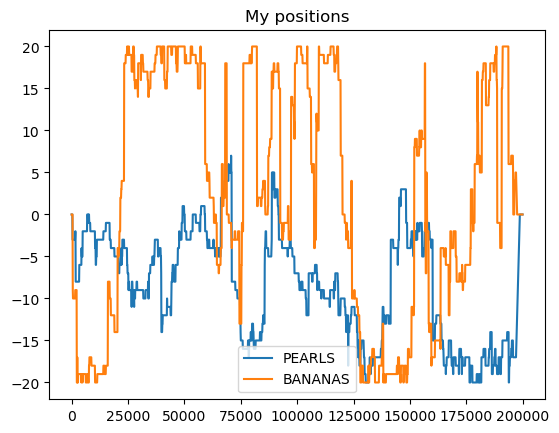

In [22]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

In [23]:
# distribution of price movements

col = book_tops[["BANANAS_mid", "PEARLS_mid"]]
diffs = (col.shift(-1) / col).dropna()
diffs.describe().T

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1999.0,1.000001,0.000338,0.998777,0.999796,1.0,1.000204,1.001227
PEARLS_mid,1999.0,1.000000,0.000212,0.999300,0.999900,1.0,1.000100,1.000700


In [24]:
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,689.0,2.844702,3.150393,1.0,1.0,1.0,1.0,2.0,3.0,6.0,17.12,23.0


In [25]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2000.0,5.2795,1.892134,1.0,5.0,6.0,7.0,7.0


In [26]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



total prof 1538.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,330.0,1.940909,1.232288,0.0,0.500,2.5,3.000,4.0
rtn_0,330.0,0.887879,2.801623,-5.5,-1.500,1.5,3.000,6.5
rtn_1,330.0,0.875758,2.816800,-5.5,-1.875,1.5,3.000,7.5
rtn_10,330.0,0.990909,3.120173,-7.5,-1.500,1.5,3.500,8.5
rtn_30,330.0,1.033333,3.745771,-10.5,-1.875,1.0,3.875,10.0
rtn_100,330.0,1.012121,5.210742,-12.0,-2.500,1.0,5.000,13.0


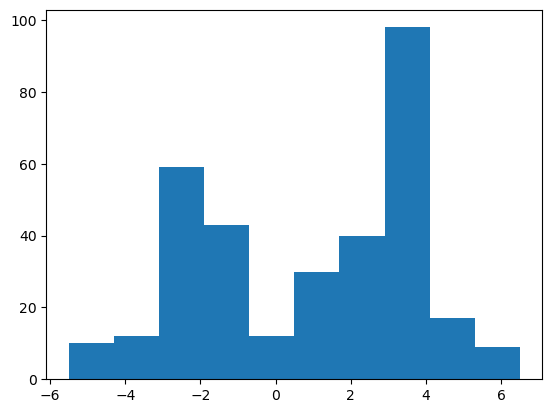

In [27]:
sym = "BANANAS"
waits=[-1, 0, 1, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

In [28]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

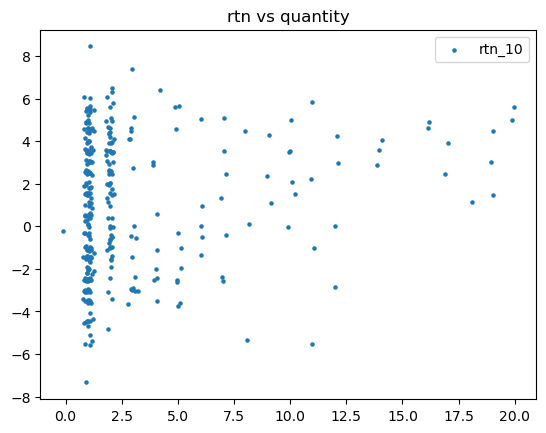

In [29]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_10"], std=0.1), s=5, label="rtn_10")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



In [41]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
display(sizes.describe().T)
big_days = sizes[sizes["quantity"] >= 15]

df[df["time"].isin(big_days.index)]

,count,mean,std,min,25%,50%,75%,max
quantity,314.0,1.716561,1.582425,1.0,1.0,1.0,2.0,13.0


,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,PEARLS_30,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_10,rtn_30,rtn_100,rtn_0_total


total prof 1012.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,338.0,2.627219,1.471822,-0.0,1.0,3.0,4.0,5.0
rtn_0,338.0,1.418639,3.440254,-5.5,-2.0,2.0,4.0,8.5
rtn_1,338.0,1.525148,3.394461,-5.5,-2.0,2.0,4.0,8.0
rtn_10,338.0,1.436391,3.421386,-5.5,-2.0,2.0,4.0,8.5
rtn_30,338.0,1.393491,3.369952,-5.5,-2.0,2.0,4.0,8.5
rtn_100,338.0,1.392012,3.310494,-5.5,-2.0,2.0,4.0,8.0


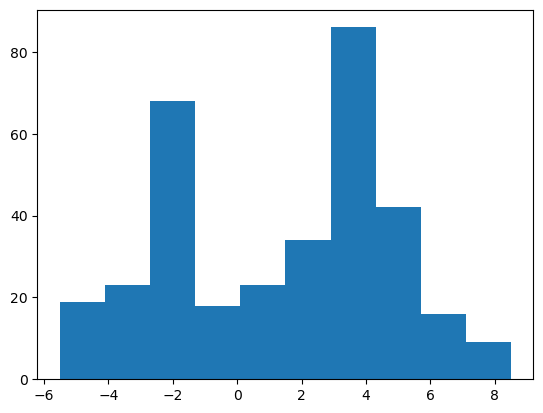

In [31]:
sym = "PEARLS"
waits=[-1, 0, 1, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

In [32]:
raw_df["book"][3]

{'BANANAS': {'buy_orders': {'4893': 25},
  'sell_orders': {'4899': -2, '4900': -23}},
 'PEARLS': {'buy_orders': {'9995': 23, '9996': 2},
  'sell_orders': {'9998': -3, '10004': -2, '10005': -23}}}

In [33]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
turn,,,,,,,,,
0,4893.0,4899.0,4896.0,6.0,9998.0,10005.0,10001.5,7.0,0
1,4892.0,4896.0,4894.0,4.0,9996.0,10002.0,9999.0,6.0,100
2,4892.0,4899.0,4895.5,7.0,9996.0,10004.0,10000.0,8.0,200
3,4893.0,4899.0,4896.0,6.0,9996.0,9998.0,9997.0,2.0,300
4,4894.0,4899.0,4896.5,5.0,9998.0,10004.0,10001.0,6.0,400
...,...,...,...,...,...,...,...,...,...
1995,4905.0,4912.0,4908.5,7.0,9996.0,9998.0,9997.0,2.0,199500
1996,4905.0,4912.0,4908.5,7.0,9995.0,10005.0,10000.0,10.0,199600
1997,4905.0,4911.0,4908.0,6.0,10002.0,10004.0,10003.0,2.0,199700


In [34]:
df["PEARLS_-1"]

0       9997.0
1      10003.0
2      10003.0
3      10003.0
4      10000.0
        ...   
333    10000.0
334    10003.0
335    10000.0
336    10000.0
337    10001.0
Name: PEARLS_-1, Length: 338, dtype: float64

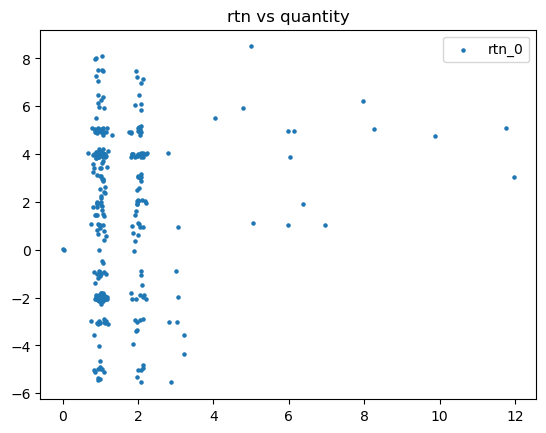

In [35]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



In [36]:
df["rtn_-1"]

0      1.0
1      1.0
2      1.0
3      1.0
4      5.0
      ... 
333    4.0
334    1.0
335    5.0
336    4.0
337    3.0
Name: rtn_-1, Length: 338, dtype: float64

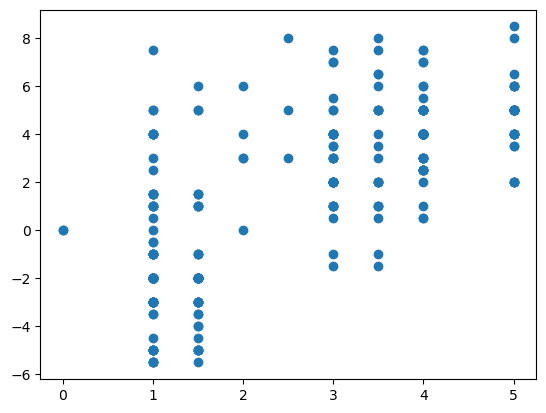

In [37]:
plt.scatter(df["rtn_-1"], df["rtn_0"])

In [38]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

In [39]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,PEARLS_30,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_10,rtn_30,rtn_100,rtn_0_total
0,,9998.0,3,SUBMISSION,PEARLS,300,400,4,True,False,...,10000.0,4898.5,10000.0,1.0,-3.0,-5.0,-2.0,-2.0,-2.0,-9.0
2,SUBMISSION,10002.0,1,,PEARLS,500,600,6,True,True,...,9996.5,4897.5,9996.5,1.0,-3.0,-0.5,-2.0,-5.5,-5.5,-3.0
3,SUBMISSION,10002.0,1,,PEARLS,1500,1600,16,True,True,...,10000.0,4895.5,10000.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
8,,9998.0,1,SUBMISSION,PEARLS,4400,4500,45,True,False,...,10000.0,4893.5,9998.0,1.0,-2.0,-2.0,-2.0,-2.0,-0.0,-2.0
9,SUBMISSION,10002.0,3,,PEARLS,4800,4900,49,True,True,...,9999.0,4895.5,9999.0,1.0,-5.5,-1.0,0.0,-3.0,-3.0,-16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,SUBMISSION,10002.0,1,,PEARLS,187600,187700,1877,True,True,...,10000.0,4905.5,9998.5,1.0,-2.0,-0.5,-2.0,-2.0,-3.5,-2.0
323,,9998.0,1,SUBMISSION,PEARLS,188200,188300,1883,True,False,...,10001.0,4904.5,9999.0,1.0,-2.0,-2.0,-2.0,-3.0,-1.0,-2.0
327,,9998.0,1,SUBMISSION,PEARLS,189800,189900,1899,True,False,...,10002.5,4909.0,10001.5,1.5,-1.0,1.0,-0.5,-4.5,-3.5,-1.0
328,,9998.0,1,SUBMISSION,PEARLS,190000,190100,1901,True,False,...,10000.0,4909.0,10001.5,1.0,-0.5,1.5,-2.0,-2.0,-3.5,-0.5


In [40]:
trade_df[trade_df["is_me"]]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade
1,,9998.0,3,SUBMISSION,PEARLS,300,400,4,True,False,True,-3,False
2,,4899.0,9,SUBMISSION,BANANAS,400,500,5,True,False,True,-9,False
3,,10004.0,1,SUBMISSION,PEARLS,500,600,6,True,False,True,-1,False
4,,4899.0,1,SUBMISSION,BANANAS,500,600,6,True,False,True,-1,False
5,SUBMISSION,10002.0,1,,PEARLS,500,600,6,True,True,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,SUBMISSION,10002.0,1,,PEARLS,198200,198300,1983,True,True,False,1,False
978,SUBMISSION,10002.0,1,,PEARLS,198300,198400,1984,True,True,False,1,False
981,SUBMISSION,10005.0,1,,PEARLS,198400,198500,1985,True,True,False,1,False
982,SUBMISSION,10002.0,1,,PEARLS,198500,198600,1986,True,True,False,1,False
